# Exmaple Lan Emden code form dedalus website
https://dedalus-project.readthedocs.io/en/latest/pages/examples/nlbvp_ball_lane_emden.html

2025-06-03 11:52:12,842 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+00/s
2025-06-03 11:52:12,845 __main__ 0/1 INFO :: Perturbation norm: 3.550e-01
2025-06-03 11:52:12,891 __main__ 0/1 INFO :: R iterate: 7.361113662674233
2025-06-03 11:52:13,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s
2025-06-03 11:52:13,010 __main__ 0/1 INFO :: Perturbation norm: 6.203e-02
2025-06-03 11:52:13,012 __main__ 0/1 INFO :: R iterate: 6.927472163516312
2025-06-03 11:52:13,135 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.4e+00/s
2025-06-03 11:52:13,138 __main__ 0/1 INFO :: Perturbation norm: 1.192e-02
2025-06-03 11:52:13,139 __main__ 0/1 INFO :: R iterate: 6.8984149771832115
2025-06-03 11:52:13,256 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s
2025-06-03 11:52:13,259 __m

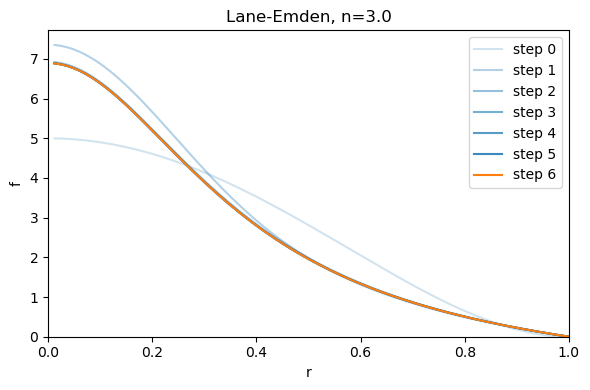

In [1]:
"""
Dedalus script solving the Lane-Emden equation. This script demonstrates
solving a spherically symmetric nonlinear boundary value problem inside the
ball. It should converge within roughly a dozen Newton iterations, and produces a
plot of the solution. I should take just a few seconds to run (serial only).

In astrophysics, the Lane-Emden equation is a dimensionless form of Poisson's
equation for the gravitational potential of a Newtonian self-gravitating,
spherically symmetric, polytropic fluid [1].

It is usually written as:
    lap(f) + f**n = 0
    f(r=0) = 1
    f(r=R) = 0
where n is the polytropic index, and the equation is solved over the interval
r=[0,R], where R is the n-dependent first zero of f(r).

Following [2], we rescale r by 1/R, giving:
    lap(f) + (R**2)*(f**n) = 0
    f(r=0) = 1
    f(r=1) = 0
This is a nonlinear eigenvalue problem over the unit ball, with the additional
boundary condition fixing the eigenvalue R.

We can eliminate R by rescaling f by R**(2/(n-1)), giving:
    lap(f) + f**n = 0
    f(r=1) = 0
and R can then be recovered from f(r=0) = R**(2/(n-1)).

For a scalar Laplacian in the ball, we need a single tau term. Here we choose
to lift it to the original (k=0) basis.

To run and plot:
    $ python3 lane_emden.py

References:
    [1]: http://en.wikipedia.org/wiki/Lane–Emden_equation
    [2]: J. P. Boyd, "Chebyshev spectral methods and the Lane-Emden problem,"
         Numerical Mathematics Theory (2011).
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Nr = 64
n = 3.0
ncc_cutoff = 1e-3
tolerance = 1e-10
dealias = 2
dtype = np.float64

# Bases
coords = d3.SphericalCoordinates('phi', 'theta', 'r')
dist = d3.Distributor(coords, dtype=dtype)
ball = d3.BallBasis(coords, (1, 1, Nr), radius=1, dtype=dtype, dealias=dealias)

# Fields
f = dist.Field(name='f', bases=ball)
tau = dist.Field(name='tau', bases=ball.surface)

# Substitutions
lift = lambda A: d3.Lift(A, ball, -1)

# Problem
problem = d3.NLBVP([f, tau], namespace=locals())
problem.add_equation("lap(f) + lift(tau) = - f**n")
problem.add_equation("f(r=1) = 0")

# Initial guess
phi, theta, r = dist.local_grids(ball)
R0 = 5
f['g'] = R0**(2/(n-1)) * (1 - r**2)**2

# Solver
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
pert_norm = np.inf
f.change_scales(dealias)
steps = [f['g'].ravel().copy()]
while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
    f0 = f(r=0).evaluate().allgather_data('g')[0,0,0]
    Ri = f0**((n-1)/2)
    logger.info(f'R iterate: {Ri}')
    steps.append(f['g'].ravel().copy())

# Compare to reference solutions from Boyd
R_ref = {0.0: np.sqrt(6),
        0.5: 2.752698054065,
        1.0: np.pi,
        1.5: 3.65375373621912608,
        2.0: 4.3528745959461246769735700,
        2.5: 5.355275459010779,
        3.0: 6.896848619376960375454528,
        3.25: 8.018937527,
        3.5: 9.535805344244850444,
        4.0: 14.971546348838095097611066,
        4.5: 31.836463244694285264}
logger.info('-'*20)
logger.info(f'Iterations: {solver.iteration}')
logger.info(f'Final R iteration: {Ri}')
if n in R_ref:
    logger.info(f'Error vs reference: {Ri-R_ref[n]:.3e}')

# Plot solution
plt.figure(figsize=(6, 4))
_, _, r = dist.local_grids(ball, scales=(dealias,dealias,dealias))
alpha = np.linspace(0.2, 1, len(steps))
color = ('C0',) * (len(steps)-1) + ('C1',)
for i, step in enumerate(steps):
    plt.plot(r.ravel(), step, c=color[i], alpha=alpha[i], label=f"step {i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, None)
plt.xlabel('r')
plt.ylabel('f')
plt.title(f"Lane-Emden, n={n}")
plt.tight_layout()
plt.savefig('lane_emden example code.pdf')
plt.savefig('lane_emden example code.png', dpi=200)